#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.10.1


In [ ]:
!pip install visualkeras
import visualkeras

### Seed

In [ ]:
# Random seed for reproducibility
seed = 69 

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Loading dataset

In [ ]:
# Load the dataset by correctly specifying the right folder where it is stored and its name
dataset_dir = 'Negative Dataset Truncated'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

### Setting all parameters

In [ ]:
# We define some dictionaries that will contain the model hyperparameters we set for a given model training. Furthermore, those will be saved in a csv file in order to keep track of trials.
# This is also a way of making our code parametric


simulation_hyperparameters = {}

simulation_hyperparameters['epochs'] = 100
simulation_hyperparameters['patience'] = 10
simulation_hyperparameters['bacth_size'] = 32
simulation_hyperparameters['batch_size_augmentation'] = 32
simulation_hyperparameters['learing_rate'] = tfk.optimizers.Adam(10**-3) # tensorflow function that requires a float value in order to compute gradient descent with a spefic learning rate
simulation_hyperparameters['monitored_value'] = 'val_accuracy'
simulation_hyperparameters['monitoring_mode'] = 'max'

# This is a check for avoiding mistakes such as number of epochs smaller than patience
assert simulation_hyperparameters['epochs'] > simulation_hyperparameters['patience']

# These parameters are important for reshaping the images, before providing it to the imported model
preparation_hyperparameters={} 

preparation_hyperparameters['input_shape_height'] = 128
preparation_hyperparameters['resized_shape_height'] = 128 # We use twice this parameters for both height and width since the dataset is composed by square images 
# A 3 components vector will be composed in the following way: (new_height, new_width, depth (always equal to 3)) and it will be fed into the TL model

# These parameters are the ones used to build our classifier to be linked to the TL model imported
classification_hyperparameters={}

classification_hyperparameters['model_cool_name'] = 'VGG16_with_new_dataset' # This is a string we use to intuitively recognize our model
classification_hyperparameters['dense_neurons_1'] = 256 # number of neurons in the first Hidden Layer
classification_hyperparameters['dense_neurons_2'] = 128 # number of neurons in the second Hidden Layer
classification_hyperparameters['dense_neurons_3'] = 0 # number of neurons in the third Hidden Layer
classification_hyperparameters['dropout_level_0'] = 0.3 # percentage of dropout neurons between GAP/Flattening layer and the first Hidden Layer
classification_hyperparameters['dropout_level_1'] = 0.3 # percentage of dropout neurons in the first Hidden Layer
classification_hyperparameters['dropout_level_2'] = 0.3 # percentage of dropout neurons in the second Hidden Layer
classification_hyperparameters['dropout_level_3'] = 0.3 # percentage of dropout neurons in the third Hidden Layer
classification_hyperparameters['activation_function_1'] = 'relu' # activation function in the first Hidden Layer
classification_hyperparameters['activation_function_2'] = 'relu' # activation function in the second Hidden Layer
classification_hyperparameters['activation_function_3'] = 'relu' # activation function in the third Hidden Layer
classification_hyperparameters['output_shape'] = 3 # number of neurons in the Output Layer (equal to the number of classes to be classified)


frozen_hyperparameters = {**simulation_hyperparameters,**preparation_hyperparameters,**classification_hyperparameters}

In [ ]:
frozen_hyperparameters

{'epochs': 100,
 'patience': 10,
 'bacth_size': 32,
 'batch_size_augmentation': 32,
 'learing_rate': <keras.optimizers.optimizer_v2.adam.Adam at 0x1d92f22b070>,
 'monitored_value': 'val_accuracy',
 'monitoring_mode': 'max',
 'input_shape_height': 128,
 'resized_shape_height': 128,
 'model_cool_name': 'VGG16_with_new_dataset',
 'dense_neurons_1': 256,
 'dense_neurons_2': 128,
 'dense_neurons_3': 0,
 'dropout_level_0': 0.3,
 'dropout_level_1': 0.3,
 'dropout_level_2': 0.3,
 'dropout_level_3': 0.3,
 'activation_function_1': 'relu',
 'activation_function_2': 'relu',
 'activation_function_3': 'relu',
 'output_shape': 3}

### Training Set Loading & Augmentation

In [ ]:
import cv2 as cv
def Median(image_pre):
    
    processed_image = cv.medianBlur(image_pre,3)
    
    return processed_image

In [ ]:
aug_train_gen = ImageDataGenerator(rotation_range = 5,
                                  height_shift_range = 15,
                                  width_shift_range = 15, 
                                  zoom_range = [0.9,1.1],
                                  horizontal_flip = False,
                                  vertical_flip = False, 
                                  fill_mode = 'constant',
                                  cval=127.5,
                                  preprocessing_function=Median
                                   )

training_set = aug_train_gen.flow_from_directory(directory = training_dir,
                                                  target_size = (preparation_hyperparameters['input_shape_height'],preparation_hyperparameters['input_shape_height']),
                                                  color_mode = 'rgb',
                                                  classes = None, 
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle = True,
                                                  seed = seed)



Found 13112 images belonging to 3 classes.


### Importing Validation and Test Set

In [ ]:
validation_set = ImageDataGenerator(preprocessing_function=Median).flow_from_directory(directory =validation_dir,
                                                  target_size = (preparation_hyperparameters['input_shape_height'],preparation_hyperparameters['input_shape_height']),
                                                  color_mode = 'rgb',
                                                  classes = None, 
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle = True,
                                                  seed = seed)


test_set = ImageDataGenerator(preprocessing_function=Median).flow_from_directory(directory = test_dir,
                                                  target_size = (preparation_hyperparameters['input_shape_height'],preparation_hyperparameters['input_shape_height']),
                                                  color_mode = 'rgb',
                                                  classes = None, 
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle = False,
                                                  seed = seed)

Found 4642 images belonging to 3 classes.
Found 1548 images belonging to 3 classes.


#Model

##Transfer learning

### Importing TL Model

In [ ]:
# Download and plot the model

supernet = tfk.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(preparation_hyperparameters['resized_shape_height'],preparation_hyperparameters['resized_shape_height'],3),
)

supernet.summary()
tfk.utils.plot_model(supernet)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

### Building Classifier
Here we build our own classifier

Model: "VGG16_with_new_dataset"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 

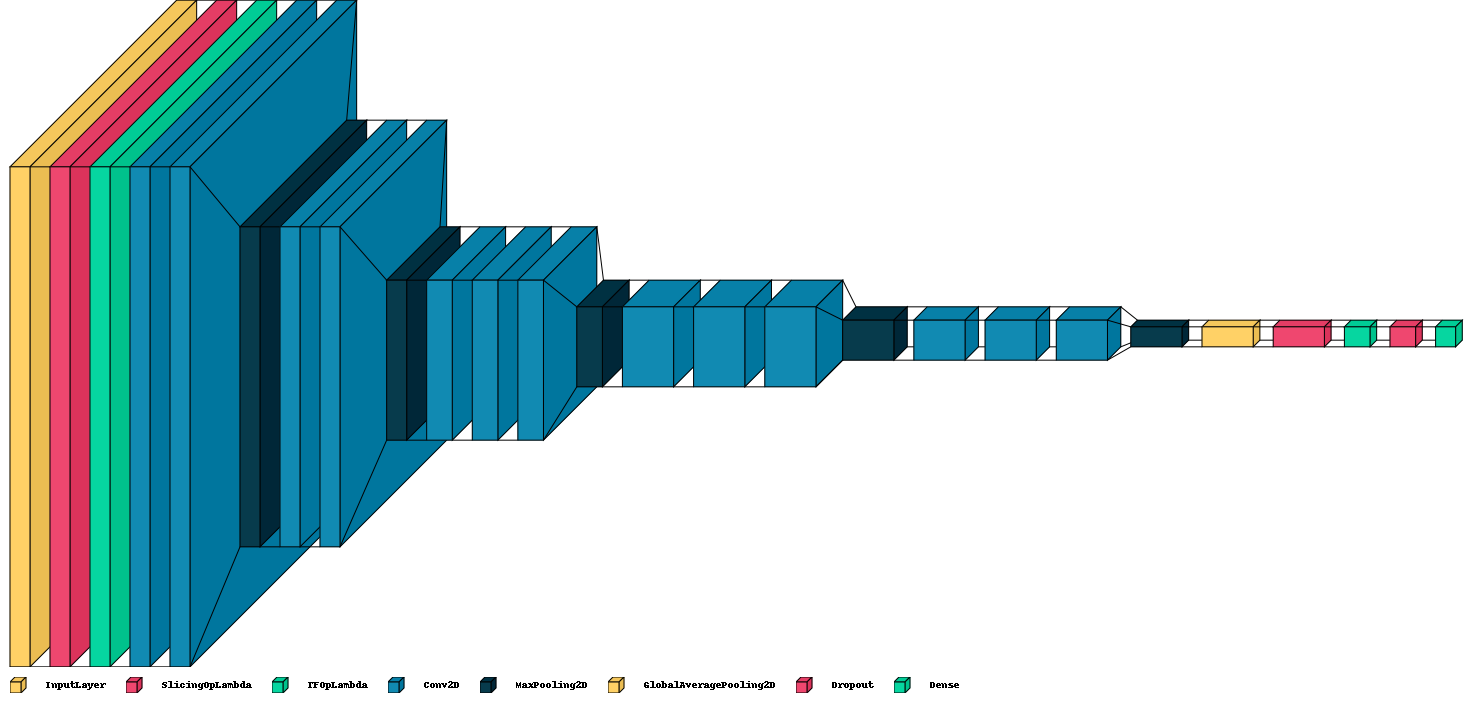

In [ ]:
# Use the supernet as feature extractor

supernet.trainable = False

shape_input = (preparation_hyperparameters['input_shape_height'], preparation_hyperparameters['input_shape_height'], 3)
Input_layer = tfk.Input(shape = shape_input)

Preprocessing_layer = tfk.applications.vgg16.preprocess_input(Input_layer)

#Resize_layer = tfkl.Resizing(preparation_hyperparameters['resized_shape_height'], preparation_hyperparameters['resized_shape_height'], interpolation = "bicubic")(Preprocessing_layer)

feature_extractor = supernet.call(Preprocessing_layer)

Gap_layer = tfkl.GlobalAveragePooling2D(name = 'gap')(feature_extractor)

Dropout_layer_0 = tfkl.Dropout(classification_hyperparameters['dropout_level_0'], seed=seed)(Gap_layer)

Hidden_layer_2 = tfkl.Dense(
    256, 
    activation = classification_hyperparameters['activation_function_2'],
    kernel_initializer = tfk.initializers.HeUniform(seed),
    kernel_regularizer = tfk.regularizers.l2(l = 0.01))(Dropout_layer_0)

Dropout_layer_2 = tfkl.Dropout(classification_hyperparameters['dropout_level_2'], seed = seed)(Hidden_layer_2)

Output_layer = tfkl.Dense(
    classification_hyperparameters['output_shape'], 
    activation = 'softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(Dropout_layer_2)

# Connect input and output through the Model class
Frozen_TL_model = tfk.Model(inputs = Input_layer, outputs = Output_layer, name = classification_hyperparameters['model_cool_name'])

# Compile the model
Frozen_TL_model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = simulation_hyperparameters['learing_rate'], metrics = 'accuracy')
Frozen_TL_model.summary()

visualkeras.layered_view(Frozen_TL_model, legend = True, spacing = 20, scale_xy = 5, max_xy = 500)

### Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
total_samples = len(training_set.filenames)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(training_set.classes), y=training_set.classes)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# We do the training

Frozen_TL_history = Frozen_TL_model.fit(
     x = training_set,
     class_weight = class_weight_dict,
     batch_size = simulation_hyperparameters['bacth_size'],
     epochs = simulation_hyperparameters['epochs'],
     validation_data = validation_set,
     callbacks = [tfk.callbacks.EarlyStopping(monitor = simulation_hyperparameters['monitored_value'], 
                                              mode = simulation_hyperparameters['monitoring_mode'],
                                              patience=10, 
                                              restore_best_weights=True)]
  ).history

Epoch 1/100
410/410 [==============================] - 197s 479ms/step - loss: 2.5489 - accuracy: 0.6480 - val_loss: 1.0179 - val_accuracy: 0.8412
Epoch 2/100
410/410 [==============================] - 199s 485ms/step - loss: 1.0156 - accuracy: 0.6934 - val_loss: 0.6379 - val_accuracy: 0.8697
Epoch 3/100
410/410 [==============================] - 199s 485ms/step - loss: 0.8097 - accuracy: 0.7049 - val_loss: 0.5571 - val_accuracy: 0.8621
Epoch 4/100
410/410 [==============================] - 198s 484ms/step - loss: 0.7255 - accuracy: 0.7158 - val_loss: 0.4965 - val_accuracy: 0.8716
Epoch 5/100
410/410 [==============================] - 208s 507ms/step - loss: 0.6975 - accuracy: 0.7213 - val_loss: 0.5123 - val_accuracy: 0.8533
Epoch 6/100
410/410 [==============================] - 199s 485ms/step - loss: 0.6734 - accuracy: 0.7304 - val_loss: 0.5585 - val_accuracy: 0.8126
Epoch 7/100
410/410 [==============================] - 199s 486ms/step - loss: 0.6705 - accuracy: 0.7182 - val_loss: 0

### Plotting results

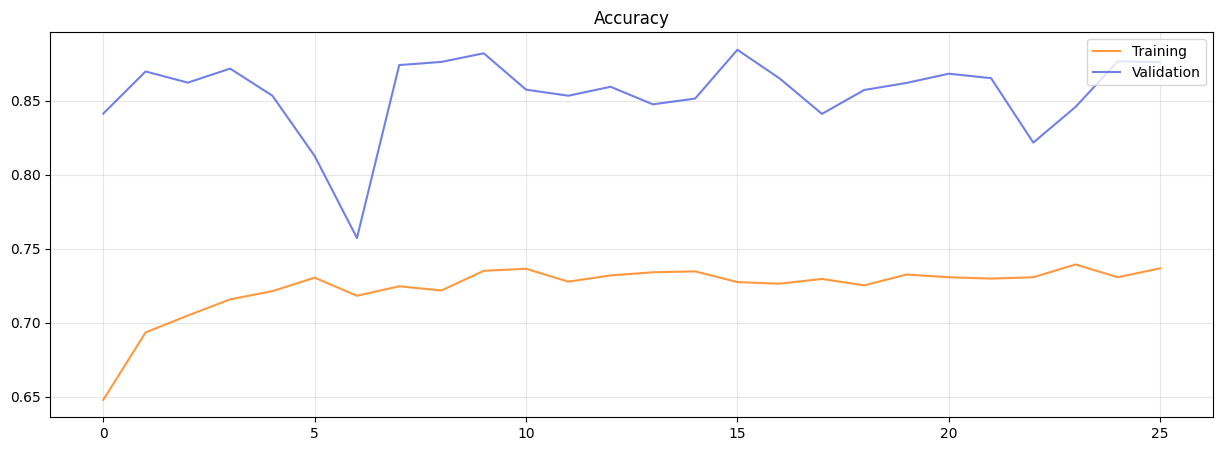

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(Frozen_TL_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(Frozen_TL_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.title('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(alpha = .3)
plt.show()

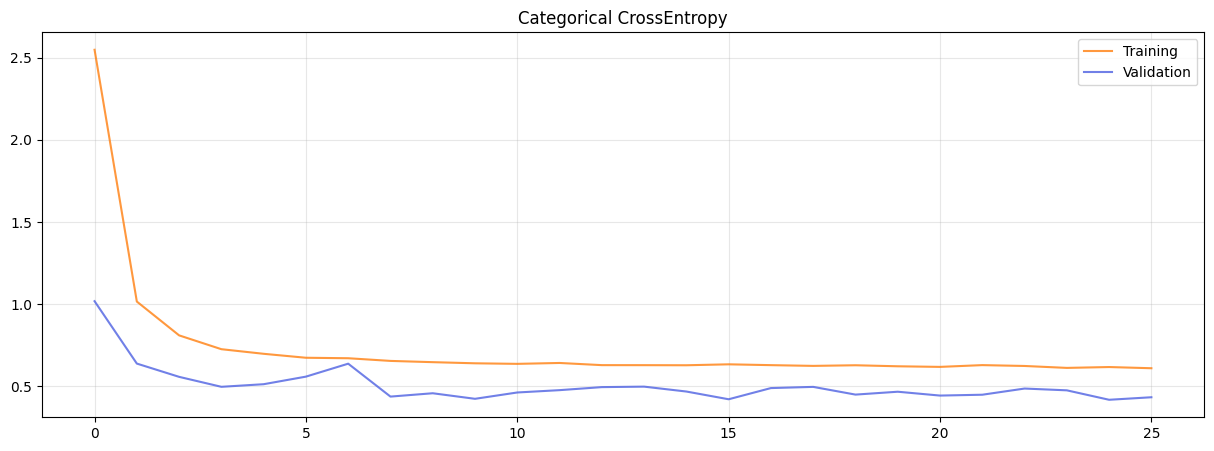

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(Frozen_TL_history['loss'], label = 'Training', alpha = .8, color = '#ff7f0e')
plt.plot(Frozen_TL_history['val_loss'], label = 'Validation', alpha = .8, color = '#4D61E2')
plt.title('Categorical CrossEntropy')
plt.legend(loc = 'upper right')
plt.grid(alpha = .3)
plt.show()

In [ ]:
[test_loss, test_accuracy] = Frozen_TL_model.evaluate(test_set)

49/49 [==============================] - 15s 300ms/step - loss: 0.4260 - accuracy: 0.8734


### Save Model

In [ ]:
Frozen_TL_model.save('Primo modello VGG no BN always128 with Negatives augmentation no H-flip CW median')

INFO:tensorflow:Assets written to: Primo modello VGG no BN always128 with Negatives augmentation no H-flip CW median\assets


INFO:tensorflow:Assets written to: Primo modello VGG no BN always128 with Negatives augmentation no H-flip CW median\assets


##Fine Tuning

####Load the model and unfreeze some of the layers

In [ ]:
FT_model= tfk.models.load_model('Primo modello VGG no BN always128 with Negatives augmentation no H-flip CW median')

In [ ]:
supernet.trainable = True

In [ ]:
# Set all ########### layers to True
FT_model.trainable = True
FT_model.summary()

Model: "VGG16_with_new_dataset"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 

In [ ]:
#Show all the layers and if are trainable or not
for i, layer in enumerate(FT_model.layers):
   print(i, layer.name, layer.trainable)
FT_model.summary()

0 input_4 True
1 tf.__operators__.getitem_1 True
2 tf.nn.bias_add_1 True
3 block1_conv1 True
4 block1_conv2 True
5 block1_pool True
6 block2_conv1 True
7 block2_conv2 True
8 block2_pool True
9 block3_conv1 True
10 block3_conv2 True
11 block3_conv3 True
12 block3_pool True
13 block4_conv1 True
14 block4_conv2 True
15 block4_conv3 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_pool True
21 gap True
22 dropout_2 True
23 dense_2 True
24 dropout_3 True
25 dense_3 True
Model: "VGG16_with_new_dataset"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                     

####Compile and train

In [ ]:
#Compile the model
FT_model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(10**-4), metrics = 'accuracy')


In [ ]:
#Training of the model

finetuned_history = FT_model.fit(
     x = training_set,
     class_weight = class_weight_dict,
     batch_size = simulation_hyperparameters['bacth_size'],
     epochs = simulation_hyperparameters['epochs'],
     validation_data = validation_set,
     verbose = 1,
     callbacks = [tfk.callbacks.EarlyStopping(monitor = simulation_hyperparameters['monitored_value'], 
                                              mode = simulation_hyperparameters['monitoring_mode'],
                                              patience = simulation_hyperparameters['patience'], 
                                              restore_best_weights = True),
                  tfk.callbacks.ReduceLROnPlateau(monitor = simulation_hyperparameters['monitored_value'],
                                                  patience = 4,
                                                  factor = 0.1,
                                                  min_lr = 1e-8)]
  ).history



Epoch 1/100
410/410 [==============================] - 255s 591ms/step - loss: 0.7096 - accuracy: 0.6309 - val_loss: 0.5169 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 2/100
410/410 [==============================] - 245s 598ms/step - loss: 0.4192 - accuracy: 0.8221 - val_loss: 0.2892 - val_accuracy: 0.9082 - lr: 1.0000e-04
Epoch 3/100
410/410 [==============================] - 248s 604ms/step - loss: 0.3021 - accuracy: 0.8784 - val_loss: 0.2526 - val_accuracy: 0.9093 - lr: 1.0000e-04
Epoch 4/100
410/410 [==============================] - 249s 607ms/step - loss: 0.2470 - accuracy: 0.9012 - val_loss: 0.2268 - val_accuracy: 0.9205 - lr: 1.0000e-04
Epoch 5/100
410/410 [==============================] - 253s 616ms/step - loss: 0.2270 - accuracy: 0.9103 - val_loss: 0.2564 - val_accuracy: 0.9020 - lr: 1.0000e-04
Epoch 6/100
410/410 [==============================] - 249s 607ms/step - loss: 0.1842 - accuracy: 0.9246 - val_loss: 0.2269 - val_accuracy: 0.9166 - lr: 1.0000e-04
Epoch 7/100
410/

#### Plotting results

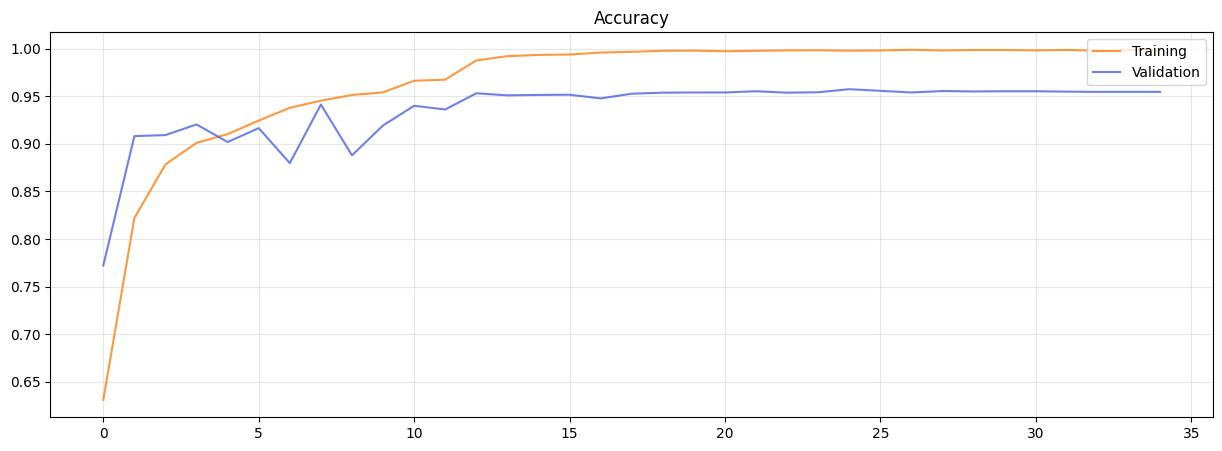

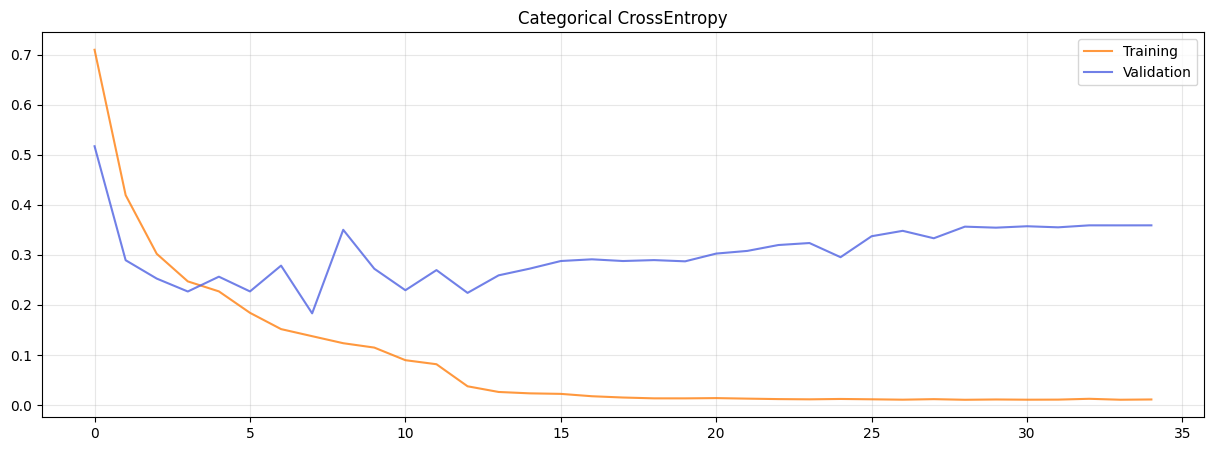

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(finetuned_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(finetuned_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.title('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(alpha = .3)
plt.show()

plt.figure(figsize = (15,5))
plt.plot(finetuned_history['loss'], label = 'Training', alpha = .8, color = '#ff7f0e')
plt.plot(finetuned_history['val_loss'], label = 'Validation', alpha = .8, color = '#4D61E2')
plt.title('Categorical CrossEntropy')
plt.legend(loc = 'upper right')
plt.grid(alpha = .3)
plt.show()



####Compute accuracy of the model

In [ ]:
[test_loss, test_accuracy] = FT_model.evaluate(test_set)

49/49 [==============================] - 13s 266ms/step - loss: 0.4044 - accuracy: 0.9496


####Save the model

In [ ]:
FT_model.save('Primo_training_VGG_tuned no BN always128 with Negatives augmentation no H-flip CW median')

INFO:tensorflow:Assets written to: Primo_training_VGG_tuned no BN always128 with Negatives augmentation no H-flip CW median\assets


INFO:tensorflow:Assets written to: Primo_training_VGG_tuned no BN always128 with Negatives augmentation no H-flip CW median\assets


#### Confusion matrix and metrics


In [ ]:
labels = ['N','P','T']

C:\Users\aless\AppData\Local\Temp\ipykernel_6500\1477748311.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = FT_model.predict_generator(test_set)


Accuracy: 0.9496
Precision: 0.9287
Recall: 0.9303
F1: 0.9294


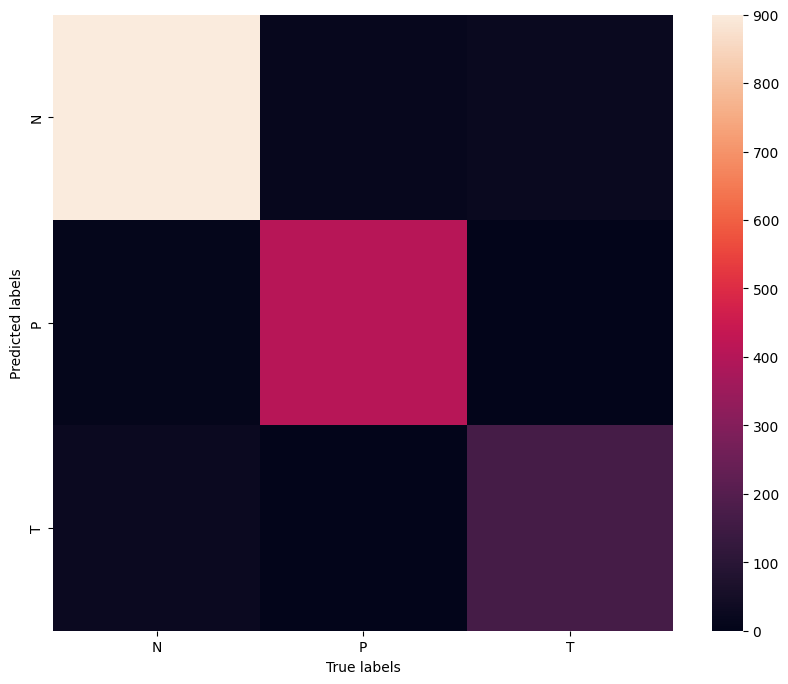

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = FT_model.predict_generator(test_set)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix

cm = (confusion_matrix(test_set.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_set.classes, predicted_classes)
precision = precision_score(test_set.classes, predicted_classes, average='macro')
recall = recall_score(test_set.classes, predicted_classes, average='macro')
f1 = f1_score(test_set.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()